In [1]:
import pandas as pd

In [2]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams

from statsmodels.tsa.stattools import adfuller
!pip install pmdarima --quiet
import pmdarima as pm

In [5]:
df = pd.read_csv("Datos_imputados_data_2.csv")[:-3]

#string to date format
df['Fecha'] = pd.to_datetime(df['Fecha'],infer_datetime_format=True)
df = df.set_index(['Fecha'])
df = df[["Tasa de desocupación "]]
df.head(5)

,Tasa de desocupación
Fecha,
2010-03-01,9.227598
2010-04-01,8.836054
2010-05-01,9.087731
2010-06-01,8.656064
2010-07-01,8.511179


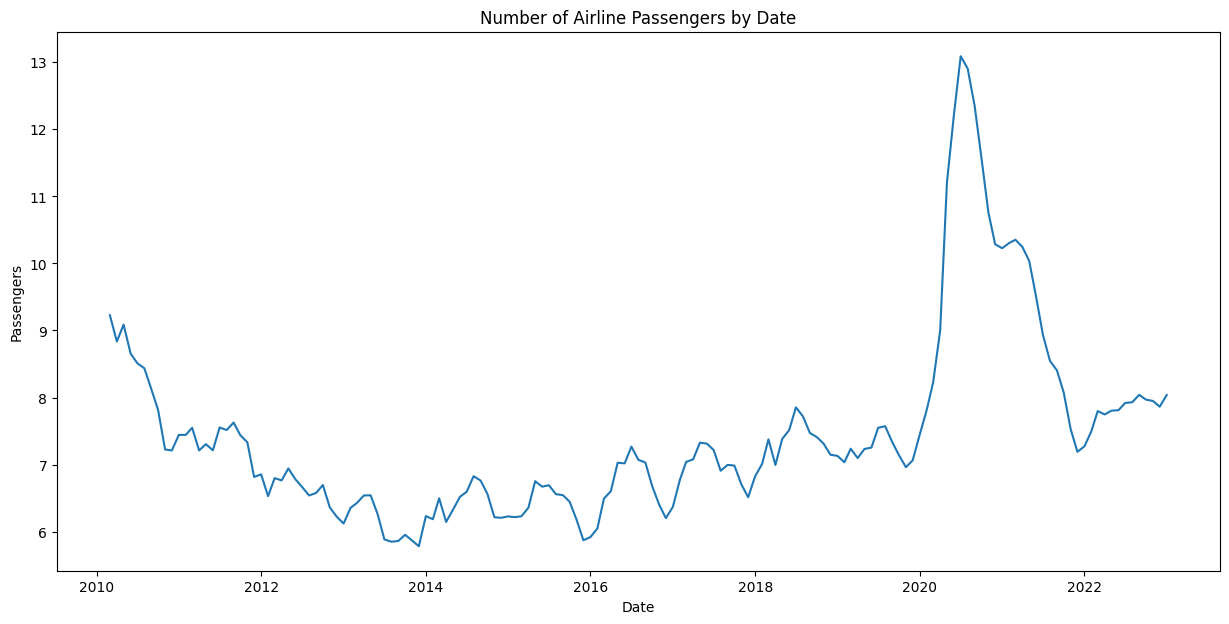

In [6]:
plt.figure(figsize=(15,7))
plt.title("Tasa desocupación ")
plt.xlabel('Fecha')
plt.ylabel('Tasa')
plt.plot(df)
plt.show()

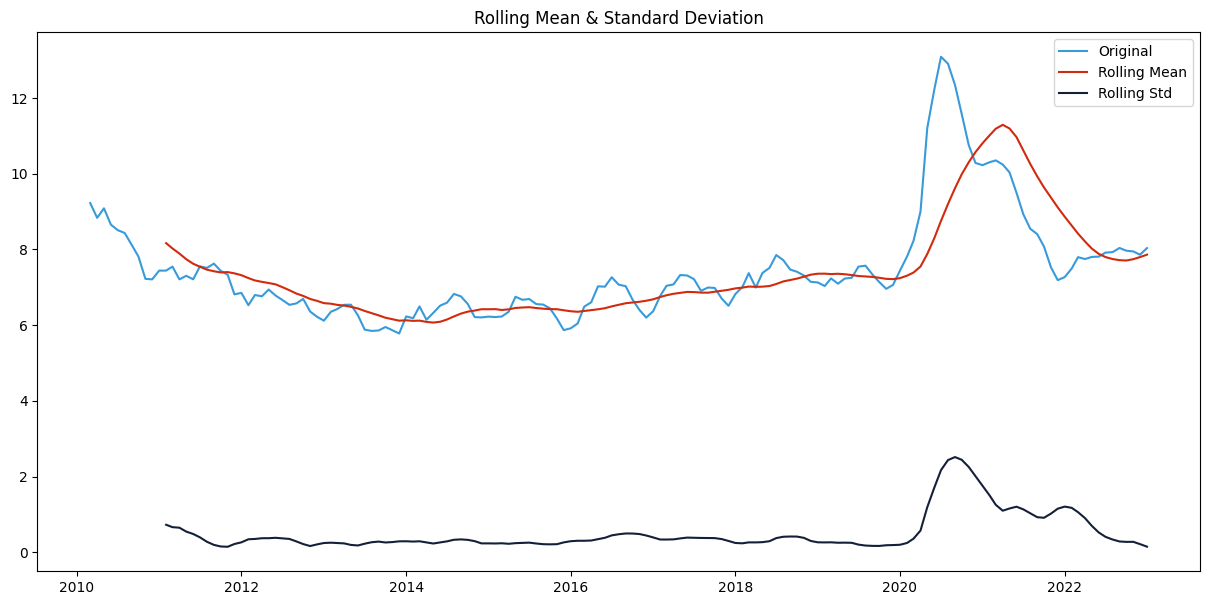

In [7]:
#Determine rolling statistics
df["rolling_avg"] = df["Tasa de desocupación "].rolling(window=12).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
df["rolling_std"] = df["Tasa de desocupación "].rolling(window=12).std()

#Plot rolling statistics
plt.figure(figsize=(15,7))
plt.plot(df["Tasa de desocupación "], color='#379BDB', label='Original')
plt.plot(df["rolling_avg"], color='#D22A0D', label='Rolling Mean')
plt.plot(df["rolling_std"], color='#142039', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [8]:
#Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(df["Tasa de desocupación "], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                  -2.257912
p-value                          0.185902
#Lags Used                      10.000000
Number of Observations Used    144.000000
Critical Value (1%)             -3.476598
Critical Value (5%)             -2.881829
Critical Value (10%)            -2.577589
dtype: float64


ARIMA Y SARIMA

In [51]:
def forecast(ARIMA_model, periods=3):
    # Forecast
    n_periods = periods
    fitted, confint = ARIMA_model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(np.log(df["Tasa de desocupación "]), color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("ARIMA/SARIMA - Predicción")
    plt.show()
    return fitted_series

In [9]:
#Standard ARIMA Model
ARIMA_model = pm.auto_arima(df["Tasa de desocupación "], 
                      start_p=1, 
                      start_q=1,
                      test='adf', # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=12, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                      d=None,# let model determine 'd'
                      seasonal=True, # No Seasonality for standard ARIMA
                      trace=False, #logs 
                      error_action='warn', #shows errors ('ignore' silences these)
                      suppress_warnings=True,
                      stepwise=True)

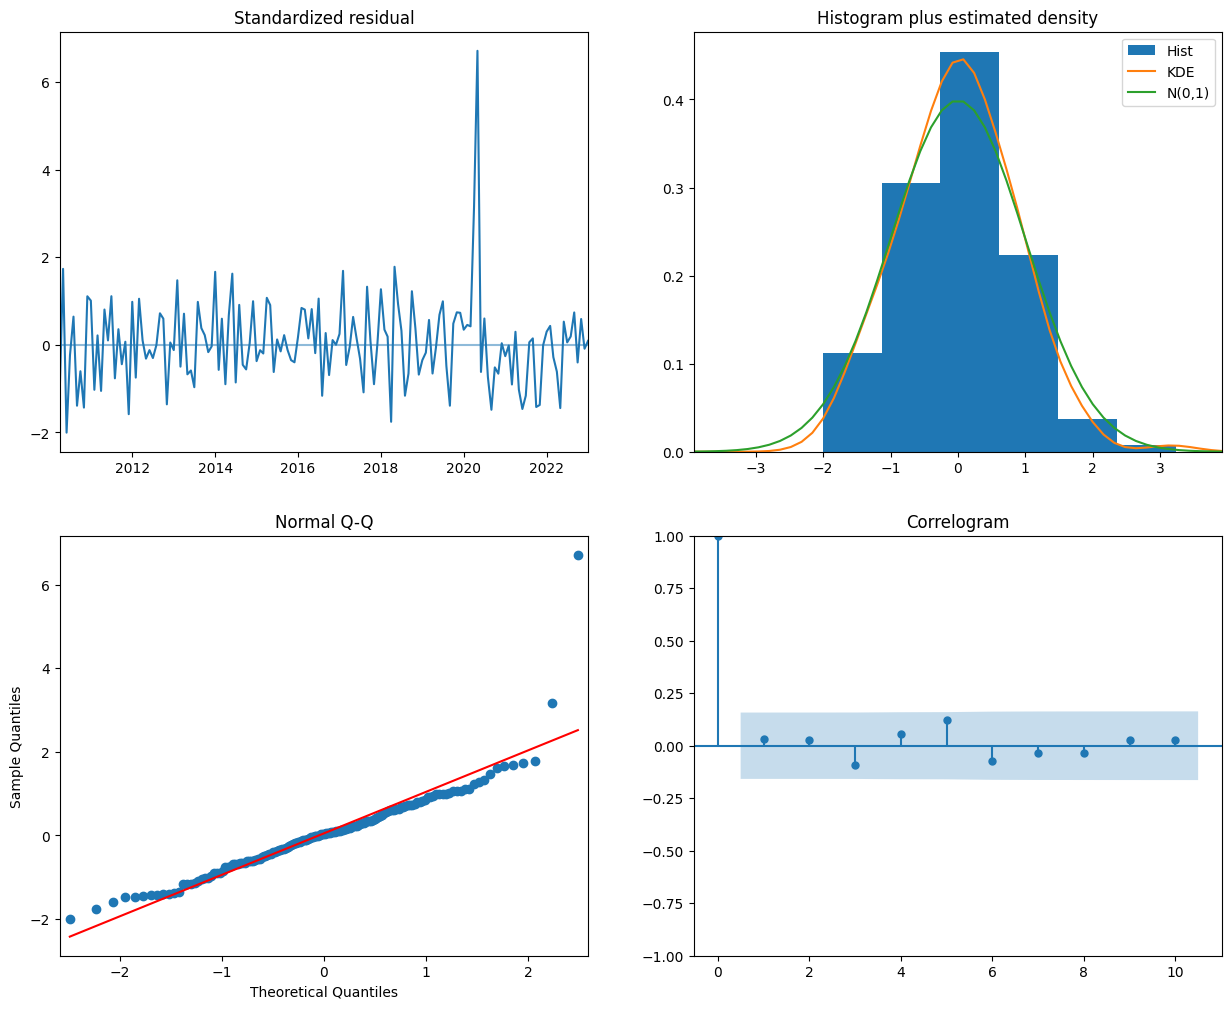

In [10]:
ARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

In [12]:
# Seasonal - fit stepwise auto-ARIMA
SARIMA_model = pm.auto_arima(np.log(df["Tasa de desocupación "]), start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, 
                         m=12, #12 is the frequncy of the cycle
                         start_P=0, 
                         seasonal=True, #set to seasonal
                         d=None, 
                         D=1, #order of the seasonal differencing
                         trace=False,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

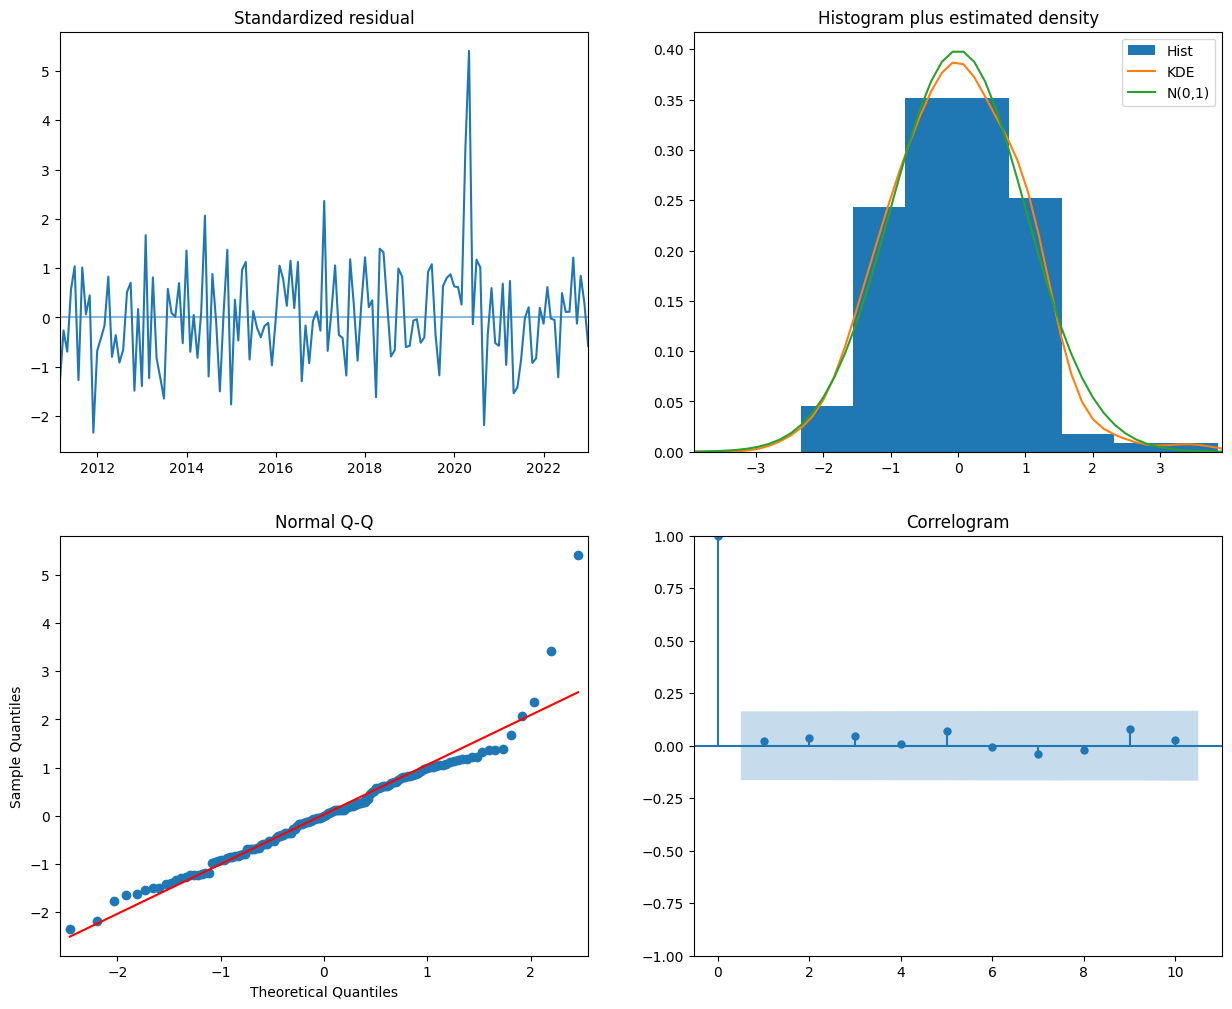

In [13]:
SARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

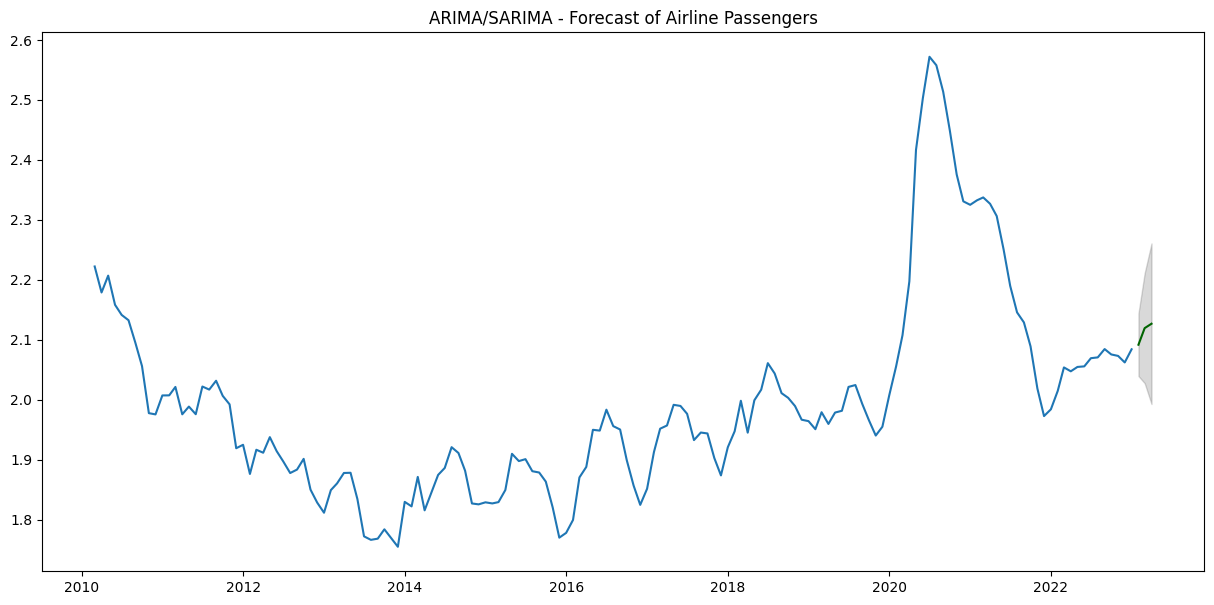

In [19]:
results_sa = forecast(SARIMA_model)


Testing

In [16]:
df2 = pd.read_csv("Datos_imputados_data_2.csv")[-3:]

#string to date format
df2['Fecha'] = pd.to_datetime(df2['Fecha'],infer_datetime_format=True)
df2 = df2.set_index(['Fecha'])
df2 = df2[["Tasa de desocupación "]]

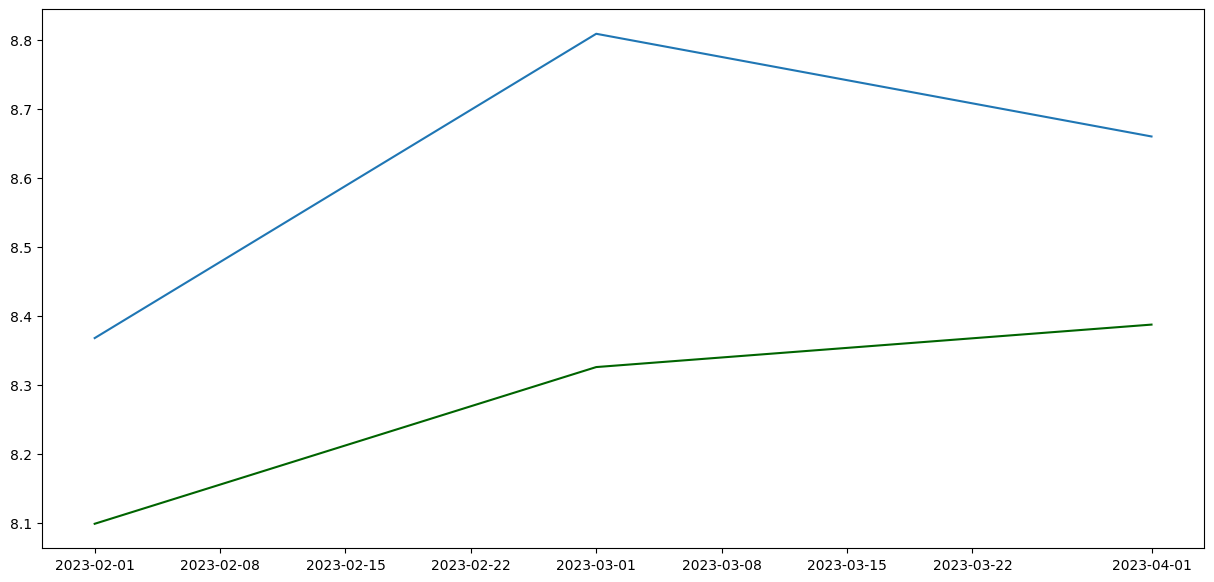

In [28]:
plt.figure(figsize=(15,7))
plt.plot(df2["Tasa de desocupación "], color='#1f76b4')
plt.plot(np.exp(results_sa), color='darkgreen')

R^2: -2.7753794383238626


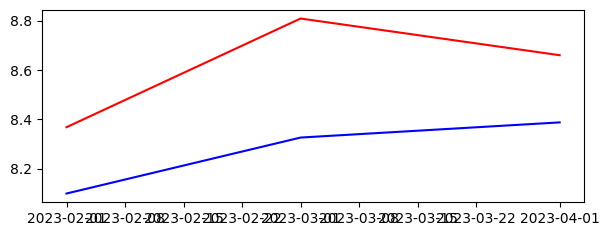

Delta : Fecha
2023-02-01    0.269014
2023-03-01    0.482832
2023-04-01    0.272536
dtype: float64


In [34]:
from sklearn.metrics import r2_score, mean_squared_error

r2 = r2_score(df2["Tasa de desocupación "], np.exp(results_sa))


print("R^2:", r2)

fig, ax = plt.subplots(figsize=(7, 2.5))
plt.plot(df2["Tasa de desocupación "],color="red",label="real")
plt.plot(np.exp(results_sa),color="blue",label="predicted")
plt.show()
print(f"Delta : {df2['Tasa de desocupación ']-np.exp(results_sa)}") 

LSTM

Fecha
2022-09-01    2.084432
2022-10-01    2.075481
2022-11-01    2.073024
2022-12-01    2.062136
2023-01-01    2.084086
Name: Tasa de desocupación , dtype: float64


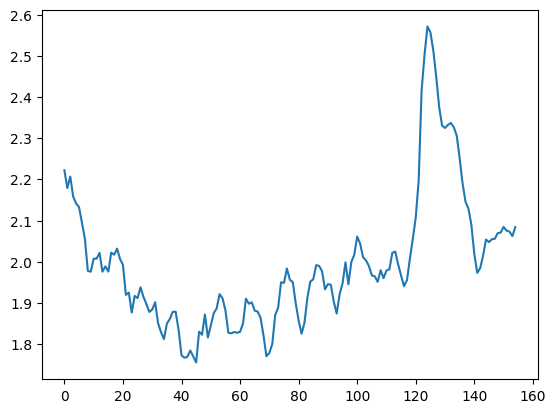

x-train:
 [[0.57204312]
 [0.51898836]
 [0.55335389]
 [0.49380563]
 [0.47315109]] 
y-train:
 [[0.51898836]
 [0.55335389]
 [0.49380563]
 [0.47315109]
 [0.46233469]]
Epoch 1/200
5/5 [==============================] - 1s 11ms/step - loss: 0.0905
Epoch 2/200
5/5 [==============================] - 0s 11ms/step - loss: 0.0547
Epoch 3/200
5/5 [==============================] - 0s 11ms/step - loss: 0.0321
Epoch 4/200
5/5 [==============================] - 0s 11ms/step - loss: 0.0229
Epoch 5/200
5/5 [==============================] - 0s 11ms/step - loss: 0.0202
Epoch 6/200
5/5 [==============================] - 0s 11ms/step - loss: 0.0210
Epoch 7/200
5/5 [==============================] - 0s 11ms/step - loss: 0.0215
Epoch 8/200
5/5 [==============================] - 0s 11ms/step - loss: 0.0209
Epoch 9/200
5/5 [==============================] - 0s 11ms/step - loss: 0.0200
Epoch 10/200
5/5 [==============================] - 0s 11ms/step - loss: 0.0194
Epoch 11/200
5/5 [============================

In [45]:
import pandas as pd
#Importing Keras 
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
import numpy as np
from keras.layers import LSTM
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

training_set=np.log(pd.read_csv("Datos_imputados_data_2.csv",index_col=["Fecha"])["Tasa de desocupación "][:-3])
print(training_set.tail())
training_set=training_set.values

from sklearn.preprocessing import MinMaxScaler
sc=MinMaxScaler()
training_set=training_set.reshape(-1,1)
training_set=sc.fit_transform(training_set)
x_train=training_set[0:len(training_set)-1]
y_train=training_set[1:len(training_set)]
#print("x-train:\n",x_train[:5],"\ny-train:\n",y_train[:5])

x_train=np.reshape(x_train,(len(training_set)-1,1,1))

regressor=Sequential()
regressor.add(LSTM(70,activation="sigmoid",input_shape=(None,1)))
regressor.add(Dense(units=1))
regressor.compile(optimizer='adam', loss=tf.keras.losses.Huber())
regressor.fit(x_train,y_train,batch_size=32,epochs=200)

test_set=np.log(pd.read_csv("Datos_imputados_data_2.csv",index_col=["Fecha"])["Tasa de desocupación "][-3:])
real=test_set.values.reshape(-1,1)


inputs=real
inputs=sc.transform(inputs)
inputs=np.reshape(inputs,(3,1,1))
predicted=regressor.predict(inputs)
predicted=sc.inverse_transform(predicted)

5/5 [==============================] - 0s 3ms/step


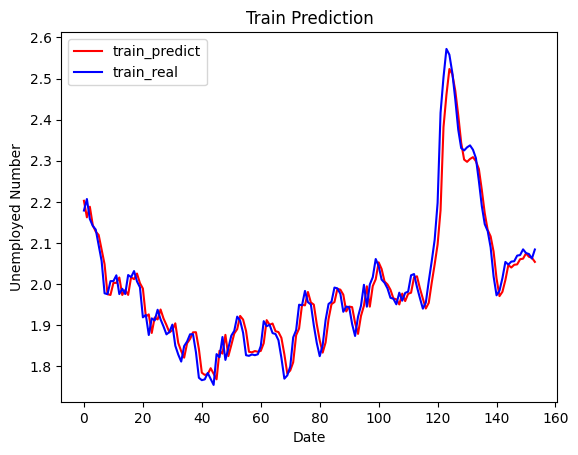

In [46]:
train_predict=regressor.predict(x_train)
train_predict=sc.inverse_transform(train_predict)
plt.plot(train_predict,color="red",label="train_predict")
plt.plot(sc.inverse_transform(y_train),color="blue",label="train_real")
plt.xlabel("Date")
plt.ylabel("Unemployed Number")
plt.title("Train Prediction")
plt.legend()
plt.show()

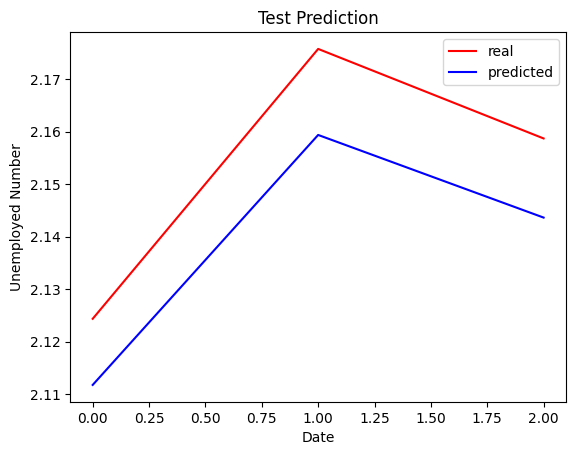

In [47]:
plt.plot(real,color="red",label="real")
plt.plot(predicted,color="blue",label="predicted")
plt.xlabel("Date")
plt.ylabel("Unemployed Number")
plt.title("Test Prediction")
plt.legend()
plt.show()

R^2: 0.5226675984184552


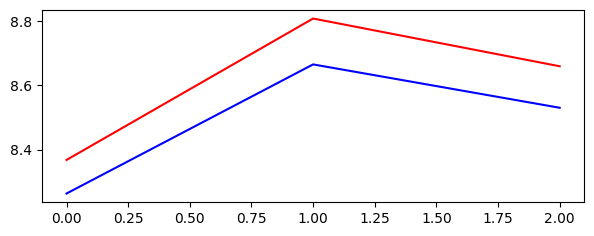

In [53]:
# Calcular R^2
from sklearn.metrics import r2_score, mean_squared_error

r2 = r2_score(real, predicted)


print("R^2:", r2)


fig, ax = plt.subplots(figsize=(7, 2.5))
plt.plot(np.exp(real),color="red",label="real")
plt.plot(np.exp(predicted),color="blue",label="predicted")
plt.show()

In [55]:
print(f"Delta: {np.exp(real) - np.exp(predicted)}")

Delta: [[0.1046325 ]
 [0.14299529]
 [0.12940111]]
